**Introduction**

This is a Google Colab Notebook which trains a PySlowFast model (using pytorchvideo) on a dataset of videos. The dataset's directory should have 3 sub-directories, one for "train", "val", and "test". In each of these directories should be more directories, named with the dataset's classes. Then, within each of these directories should be videos, whose label corresponds to the directory they are placed in (e.g. dataset->train->archery->archery_1.mph).

The "Set-up" section is used for downloading necessary packages and intiliazing variables. Take a look at the variables (such as file paths), and change them accordingly.

The "Focal Loss and Dataset Distribution" section has code that finds distribution of the used dataset and uses the information to set up Focal Loss.

The "Class Creation for Dataloaders" section creates the classes/objects necessary for creating and using dataloaders later in the process. Within this section is a commented code block which would change the transform function to one of a resnet. Uncommenting this code block, and changing the model to "make_resnet" in "Model Creation" would use a resnet50 instead.

The "Model Creation" section creates the object that is used as the Lightning Module for the model.

The "Training" section trains the model using the Trainer from Pytorch Lightning.

The "Testing" section tests the model using Trainer.test and a custom script that tests every file in the testing dataset.

The "TSNE" section makes a TSNE.

# Set-up


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext tensorboard

In [ ]:
!pip install pytorchvideo
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=b6ec3f1d7cc2d92fd662029a2ee1b2ed75cbb8381e184962bff6c2789d81e58a
  Stored in directory: /root/.cache/pip/wheels/ff/4e/81/0f72a543be9ed7eb737c95bfc5da4025e73226b44368074ece
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=3eb28bc8f6fa8051dbdbcb0eb1037f6d599f7a29b99ad65994e8c6f9568b332a
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created whee

In [ ]:
import os
import pytorch_lightning
import pytorchvideo.data
import torch.utils.data
import torchvision
import pytorchvideo
import pytorchvideo.transforms
from torch.nn.functional import softmax
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
import sklearn
#from sklearn.metrics import accuracy_score

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [ ]:
input_dir = '/content/drive/MyDrive/Research/Muscle Video/Datasets/split_workout_videos_v1'
model_name = "slowfast_r50"
checkpoint_path = '/content/drive/MyDrive/Research/Muscle Video/Checkpoints/Split/Pretrained' + '/' + model_name

num_classes=16
batch_size = 8
num_workers = 8
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
clip_duration = (num_frames * sampling_rate)/frames_per_second
device=('cuda' if torch.cuda.is_available() else 'cpu')
pretrained=True
learning_rate=0.0001
dropout_rate = 0.6
gamma = 2

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [ ]:
'''
pred_to_class = {
    0: "barbell biceps curl",
    1: "bench press",
    2: "chest fly machine",
    3: "deadlift",
    4: "decline bench press",
    5: "hammer curl",
    6: "hip thrust",
    7: "incline bench press",
    8: "lat pulldown",
    9: "lateral raise",
    10: "leg extension",
    11: "leg raises",
    12: "plank",
    13: "pull Up",
    14: "push-up",
    15: "romanian deadlift",
    16: "russian twist",
    17: "shoulder press",
    18: "squat",
    19: "t bar row",
    20: "tricep Pushdown",
    21: "tricep dips"
}
'''
pred_to_class = {
    0: "bench press",
    1: "bicep curl",
    2: "chest fly machine",
    3: "deadlift",
    4: "hip thrust",
    5: "lat pulling",
    6: "lateral raise",
    7: "leg extension",
    8: "leg raises",
    9: "push-up",
    10: "russian twist",
    11: "shoulder press",
    12: "squat",
    13: "t bar row",
    14: "tricep Pushdown",
    15: "tricep dips"
}

# Focal Loss and Dataset Distribution



In [ ]:
dataset = input_dir

In [ ]:
train_class_values = {}
test_class_values = {}
val_class_values = {}
for split in os.listdir(dataset):
  new_path = os.path.join(dataset, split)
  for classname in os.listdir(new_path):
    class_path = os.path.join(new_path, classname)
    num_samples = len(os.listdir(class_path))
    print("In the", split, "split, for the", classname, "class, there are", num_samples, "samples.")
    if split=="train":
      train_class_values[classname] = num_samples
    if split=="test":
      test_class_values[classname] = num_samples
    if split=="val":
      val_class_values[classname] = num_samples

In the train split, for the bench press class, there are 183 samples.
In the train split, for the lateral raise class, there are 67 samples.
In the train split, for the chest fly machine class, there are 49 samples.
In the train split, for the hip thrust class, there are 55 samples.
In the train split, for the deadlift class, there are 129 samples.
In the train split, for the leg extension class, there are 53 samples.
In the train split, for the push-up class, there are 78 samples.
In the train split, for the squat class, there are 77 samples.
In the train split, for the leg raises class, there are 43 samples.
In the train split, for the t bar row class, there are 60 samples.
In the train split, for the shoulder press class, there are 42 samples.
In the train split, for the russian twist class, there are 53 samples.
In the train split, for the tricep Pushdown class, there are 40 samples.
In the train split, for the tricep dips class, there are 72 samples.
In the train split, for the bi

In [ ]:
train_class_values

{'bench press': 183,
 'lateral raise': 67,
 'chest fly machine': 49,
 'hip thrust': 55,
 'deadlift': 129,
 'leg extension': 53,
 'push-up': 78,
 'squat': 77,
 'leg raises': 43,
 't bar row': 60,
 'shoulder press': 42,
 'russian twist': 53,
 'tricep Pushdown': 40,
 'tricep dips': 72,
 'bicep curl': 106,
 'lat pulling': 111}

In [ ]:
test_class_values

{'bench press': 37,
 'lateral raise': 33,
 'chest fly machine': 18,
 'hip thrust': 15,
 'deadlift': 49,
 'leg extension': 20,
 'push-up': 38,
 'squat': 39,
 'leg raises': 17,
 't bar row': 28,
 'shoulder press': 23,
 'russian twist': 19,
 'tricep Pushdown': 17,
 'tricep dips': 25,
 'bicep curl': 30,
 'lat pulling': 34}

In [ ]:
val_class_values

{'bench press': 37,
 'lateral raise': 33,
 'chest fly machine': 18,
 'hip thrust': 16,
 'deadlift': 49,
 'leg extension': 20,
 'push-up': 38,
 'squat': 39,
 'leg raises': 17,
 't bar row': 28,
 'shoulder press': 23,
 'russian twist': 19,
 'tricep Pushdown': 17,
 'tricep dips': 25,
 'bicep curl': 30,
 'lat pulling': 34}

In [ ]:
id_to_label = {
    0: [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    1: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    3: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
    4: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    5: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    6: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    7: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    8: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    9: [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    10: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
    11: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    12: [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    13: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    14: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    15: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
}

class_to_id = dict([(value, key) for key, value in pred_to_class.items()])

In [ ]:
train_label_count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for classname in train_class_values:
  id = class_to_id[classname]
  label_thing = id_to_label[id].copy()

  for x in range(0, 11):
    label_thing[x]= label_thing[x] * train_class_values[classname]
    train_label_count[x] += label_thing[x]

In [ ]:
train_label_count

[373.0, 171.0, 277.0, 130.0, 261.0, 370.0, 96.0, 53.0, 310.0, 129.0, 206.0]

In [ ]:
val_label_count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for classname in val_class_values:
  id = class_to_id[classname]
  label_thing = id_to_label[id].copy()

  for x in range(0, 11):
    label_thing[x]= label_thing[x] * val_class_values[classname]
    val_label_count[x] += label_thing[x]

In [ ]:
val_label_count

[117.0, 62.0, 92.0, 59.0, 104.0, 131.0, 36.0, 19.0, 93.0, 49.0, 88.0]

In [ ]:
test_label_count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for classname in test_class_values:
  id = class_to_id[classname]
  label_thing = id_to_label[id].copy()

  for x in range(0, 11):
    label_thing[x]= label_thing[x] * test_class_values[classname]
    test_label_count[x] += label_thing[x]

In [ ]:
test_label_count

[117.0, 62.0, 92.0, 59.0, 103.0, 131.0, 36.0, 19.0, 93.0, 49.0, 88.0]

In [ ]:
total = 0
for classname in train_class_values:
  total = total + train_class_values[classname]

In [ ]:
total

1218

In [ ]:
total_test = 0
for classname in test_class_values:
  total_test = total_test + test_class_values[classname]

In [ ]:
total_test

442

In [ ]:
total_val = 0
for classname in val_class_values:
  total_val += val_class_values[classname]

In [ ]:
total_val

443

In [ ]:
class_weights = {}
for classname in train_class_values:
  weight = 1 / (train_class_values[classname] / total)
  class_weights[classname] = weight

In [ ]:
class_weights

{'bench press': 6.655737704918033,
 'lateral raise': 18.17910447761194,
 'chest fly machine': 24.857142857142858,
 'hip thrust': 22.145454545454545,
 'deadlift': 9.44186046511628,
 'leg extension': 22.981132075471695,
 'push-up': 15.615384615384615,
 'squat': 15.818181818181817,
 'leg raises': 28.325581395348838,
 't bar row': 20.3,
 'shoulder press': 29.0,
 'russian twist': 22.981132075471695,
 'tricep Pushdown': 30.45,
 'tricep dips': 16.916666666666668,
 'bicep curl': 11.490566037735848,
 'lat pulling': 10.972972972972974}

In [ ]:
class_to_int = {}
for i in pred_to_class:
  class_to_int[pred_to_class[i]]=i

In [ ]:
class_to_int

{'bench press': 0,
 'bicep curl': 1,
 'chest fly machine': 2,
 'deadlift': 3,
 'hip thrust': 4,
 'lat pulling': 5,
 'lateral raise': 6,
 'leg extension': 7,
 'leg raises': 8,
 'push-up': 9,
 'russian twist': 10,
 'shoulder press': 11,
 'squat': 12,
 't bar row': 13,
 'tricep Pushdown': 14,
 'tricep dips': 15}

In [ ]:
list_weights = [None] * num_classes
for i in class_weights:
  list_weights[class_to_int[i]] = class_weights[i]
list_weights

[6.655737704918033,
 11.490566037735848,
 24.857142857142858,
 9.44186046511628,
 22.145454545454545,
 10.972972972972974,
 18.17910447761194,
 22.981132075471695,
 28.325581395348838,
 15.615384615384615,
 22.981132075471695,
 29.0,
 15.818181818181817,
 20.3,
 30.45,
 16.916666666666668]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torchvision.ops.focal_loss import sigmoid_focal_loss

In [ ]:
#focal_loss = sigmoid_focal_loss(alpha=class_weights, gamma=2)

# Class Creation for Dataloaders

In [ ]:
class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

def post_act(input):
  return softmax(input, dim=1)

'''
from pytorchvideo.models.slowfast import create_slowfast

def make_slowfast():
    return create_slowfast(
        input_channels=(3, 3),
        model_depth=18,
        model_num_class=num_classes,
        norm=nn.BatchNorm3d,
        dropout_rate=dropout_rate,
    )
'''

'\nfrom pytorchvideo.models.slowfast import create_slowfast\n\ndef make_slowfast():\n    return create_slowfast(\n        input_channels=(3, 3),\n        model_depth=18,\n        model_num_class=num_classes,\n        norm=nn.BatchNorm3d,\n        dropout_rate=dropout_rate,\n    )\n'

In [ ]:
class VideosDataModule(pytorch_lightning.LightningDataModule):

    # Dataset configuration
    _DATA_PATH = input_dir
    _CLIP_DURATION = clip_duration  # Duration of sampled clip for each video
    _BATCH_SIZE = batch_size
    _NUM_WORKERS = num_workers  # Number of parallel processes fetching data

    def train_dataloader(self):
        #Create the train partition from the list of video labels and video paths
        train_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'train'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=transform
        )

        return torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS
        )

    def val_dataloader(self):
        #Create the validation partition from the list of video labels and video paths
        val_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'val'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=transform
        )

        return torch.utils.data.DataLoader(
            val_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS,
        )

    def test_dataloader(self):
        test_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'test'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=transform
        )

        return torch.utils.data.DataLoader(
            test_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS,
        )

# Model Creation


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

mca1 = MulticlassAccuracy(num_classes=num_classes, average='micro', top_k=1)
mca5 = MulticlassAccuracy(num_classes=num_classes, average='micro', top_k=5)

class VideoClassificationLightningModule(pytorch_lightning.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = torch.hub.load("facebookresearch/pytorchvideo", model=model_name, pretrained=True)
        self.model.to(device)
        self.model.blocks[6].proj = nn.Linear(in_features=2304, out_features=16, bias=True)
        self.model.train()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # The model expects a video tensor of shape (B, C, T, H, W), which is the
        # format provided by the dataset
        y_hat = self.model(batch["video"])

        # Compute cross entropy loss, loss.backwards will be called behind the scenes
        # by PyTorchLightning after being returned from this method.

        loss = F.cross_entropy(y_hat, batch["label"])

        # Log the train loss to Tensorboard
        self.log("train_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("train_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("train_accuracy_top_5", acc5.item(), batch_size=batch_size)

        #last_layer = self.model.blocks[6].proj
        #embeddings = []

        print("train_loss:", loss.item(), "train_accuracy_top_1:", acc1.item(), "train_accuracy_top_5:", acc5.item())

        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        self.log("val_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("val_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("val_accuracy_top_5", acc5.item(), batch_size=batch_size)

        print("val_loss:", loss.item(), "val_accuracy_top_1:", acc1.item(), "val_accuracy_top_5:", acc5.item())

        return loss

    def configure_optimizers(self):
        """
        Setup the Adam optimizer. Note, that this function also can return a lr scheduler, which is
        usually useful for training video models.
        """
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

    def test_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        # logs metrics for each testing_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("test_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("test_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("test_accuracy_top_5", acc5.item(), batch_size=batch_size)

        softed = post_act(y_hat)
        auc = roc_auc_score(y_true=batch["label"].cpu(), y_score=softed.cpu(), multi_class='ovr', average='micro', labels=np.arange(num_classes))
        self.log("auc", auc, batch_size=batch_size)

        pred_classes = []
        for x in softed:
          class_index = x.topk(k=1).indices
          class_index = class_index[0]
          pred_classes.append(class_index)
        pred_classes = torch.Tensor(pred_classes)

        rpf1 = precision_recall_fscore_support(y_true=batch["label"].cpu(), y_pred=pred_classes.cpu(), beta=1, labels=np.arange(num_classes), average='macro', zero_division=1)
        precision = rpf1[0]
        recall = rpf1[1]
        f1 = rpf1[2]
        self.log("precision", precision, batch_size=batch_size)
        self.log("recall", recall, batch_size=batch_size)
        self.log("f1", f1, batch_size=batch_size)

        print("test_loss:", loss.item(), "test_accuracy_top_1:", acc1.item(), "test_accuracy_top_5:", acc5.item(), "auc:", auc, "precision:", precision, "recall:", recall, "f1:", f1)

        return loss

# Training

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

early_stopping_callbacks = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=True, mode="min")

In [ ]:
classification_module = VideoClassificationLightningModule()
data_module = VideosDataModule()
trainer = pytorch_lightning.Trainer(
    default_root_dir=checkpoint_path,
    max_epochs=30,
    accelerator="auto",
    devices="auto",
    strategy='auto',
    enable_checkpointing=True,
    logger=True,
)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
torch.set_float32_matmul_precision('medium')

In [ ]:
trainer.fit(classification_module, data_module, ckpt_path='/content/drive/MyDrive/Research/Muscle Video/Checkpoints/Split/Pretrained/slowfast_r101/lightning_logs/version_5/checkpoints/epoch=28-step=3754.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Research/Muscle Video/Checkpoints/Split/Pretrained/slowfast_r101/lightning_logs/version_5/checkpoints/epoch=28-step=3754.ckpt


RuntimeError: ignored

# Testing


In [ ]:
best_checkpoint_path = '/content/drive/MyDrive/Research/Muscle Video/Checkpoints/Split/Pretrained/slowfast_r50/lightning_logs/version_4/checkpoints/epoch=4-step=640.ckpt'

In [ ]:
trainer.test(model=classification_module, datamodule=data_module, ckpt_path=best_checkpoint_path, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Research/Muscle Video/Checkpoints/Split/Pretrained/slowfast_r101/lightning_logs/version_3/checkpoints/epoch=49-step=6442.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Research/Muscle Video/Checkpoints/Split/Pretrained/slowfast_r101/lightning_logs/version_3/checkpoints/epoch=49-step=6442.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

test_loss: 0.09196822345256805 test_accuracy_top_1: 1.0 test_accuracy_top_5: 1.0 auc: 1.0 precision: 1.0 recall: 1.0 f1: 1.0
test_loss: 0.11874991655349731 test_accuracy_top_1: 1.0 test_accuracy_top_5: 1.0 auc: 1.0 precision: 1.0 recall: 1.0 f1: 1.0
test_loss: 0.06732739508152008 test_accuracy_top_1: 1.0 test_accuracy_top_5: 1.0 auc: 1.0 precision: 1.0 recall: 1.0 f1: 1.0
test_loss: 0.04840409755706787 test_accuracy_top_1: 1.0 test_accuracy_top_5: 1.0 auc: 1.0 precision: 1.0 recall: 1.0 f1: 1.0
test_loss: 0.08243775367736816 test_accuracy_top_1: 1.0 test_accuracy_top_5: 1.0 auc: 1.0 precision: 1.0 recall: 1.0 f1: 1.0
test_loss: 0.2779752016067505 test_accuracy_top_1: 0.875 test_accuracy_top_5: 1.0 auc: 0.9979166666666667 precision: 0.9375 recall: 0.9375 f1: 0.875
test_loss: 0.012451879680156708 test_accuracy_top_1: 1.0 test_accuracy_top_5: 1.0 auc: 1.0 precision: 1.0 recall: 1.0 f1: 1.0
test_loss: 0.01525782234966755 test_accuracy_top_1: 1.0 test_accuracy_top_5: 1.0 auc: 1.0 precision:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            auc            │    0.9991102814674377     │
│            f1             │    0.9868924021720886     │
│         precision         │    0.9928385615348816     │
│          recall           │    0.9928385615348816     │
│    test_accuracy_top_1    │    0.9791666865348816     │
│    test_accuracy_top_5    │    0.9973958134651184     │
│         test_loss         │    0.10631709545850754    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10631709545850754,
  'test_accuracy_top_1': 0.9791666865348816,
  'test_accuracy_top_5': 0.9973958134651184,
  'auc': 0.9991102814674377,
  'precision': 0.9928385615348816,
  'recall': 0.9928385615348816,
  'f1': 0.9868924021720886}]

# TSNE

In [ ]:
TSNE_model = VideoClassificationLightningModule.load_from_checkpoint(best_checkpoint_path)
TSNE_model.to('cpu')
TSNE_model.model.blocks.pop(6)
TSNE_model.eval()
print("done")

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


done


In [ ]:
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt

In [ ]:
seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
labels = []
features = None

In [ ]:
thingy = data_module.test_dataloader()
for batch in thingy:
  x = batch["video"]
  labels += batch["label"]

  with torch.no_grad():
    output = TSNE_model(x)
    output = torch.flatten(output, 1)

  current_features = output.cpu().numpy()

  if features is not None:
    features = np.concatenate((features, current_features))
  else:
    features = current_features

In [ ]:
tsne = TSNE(n_components=2).fit_transform(features)

In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
colors_per_class = {
    0: [254, 202, 87],
    1: [255, 107, 107],
    2: [10, 189, 227],
    3: [255, 159, 243],
    4: [16, 172, 132],
    5: [128, 80, 128],
    6: [87, 101, 116],
    7: [52, 31, 151],
    8: [0, 0, 0],
    9: [100, 100, 255],
    10: [128, 109, 84],
    11: [15, 245, 218],
    12: [242, 10, 21],
    13: [242, 10, 149],
    14: [40, 242, 0],
    15: [255, 153, 10]
}

<ipython-input-52-885392fecd81>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color = np.array(colors_per_class[label], dtype=np.float) / 255
<ipython-input-52-885392fecd81>:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(current_tx, current_ty, c=color, label=label, s=15)


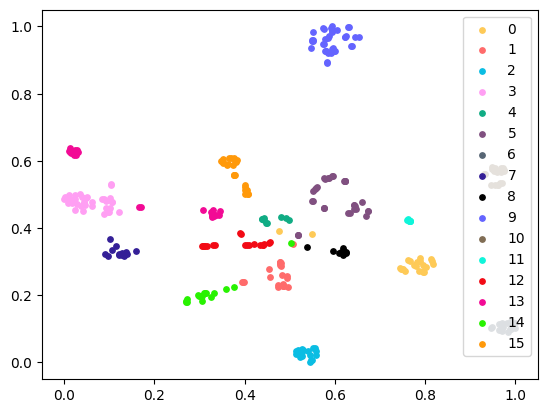

In [ ]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label, s=15)

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()